# Punto 3 - Regresion - Miguel Rios Tangarife

Librerias que vamos a utilizar

In [1]:
import glob
from PIL import Image
import random
import matplotlib.image as img
import numpy as np
import os
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import tarfile
import zipfile
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from urllib.request import urlretrieve
from os.path import isfile, isdir
import plotly.express as px
from datetime import date
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
%matplotlib inline

Leemos los datos

In [2]:
df = pd.read_excel('data/Saber_icfes_XLSX.xlsx')

Al usar "df" vemos que tenemos 68725 rows × 96 columns en un inicio

In [29]:
#df

## Sobre nulos...

Antes de analizar y filtrar aquellos variables que son más relevantes para el modelo, considero importante tener control sobre los valores nulos

Primero abordemos las variables numericas

In [3]:
df.fillna(df['PERIODO'].mean(), inplace=True)
df.fillna(df['ESTU_COD_RESIDE_DEPTO'].mean(), inplace=True)
df.fillna(df['ESTU_COD_RESIDE_MCPIO'].mean(), inplace=True)
df.fillna(df['ESTU_COD_COLE_MCPIO_TERMINO'].mean(), inplace=True)
df.fillna(df['ESTU_SNIES_PRGMACADEMICO'].mean(), inplace=True)
df.fillna(df['ESTU_PRGM_CODMUNICIPIO'].mean(), inplace=True)
df.fillna(df['ESTU_INST_CODMUNICIPIO'].mean(), inplace=True)
df.fillna(df['ESTU_COD_MCPIO_PRESENTACION'].mean(), inplace=True)
df.fillna(df['ESTU_COD_DEPTO_PRESENTACION'].mean(), inplace=True)
df.fillna(df['MOD_RAZONA_CUANTITAT_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_RAZONA_CUANTITATIVO_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_RAZONA_CUANTITATIVO_PNBC'].mean(), inplace=True)
df.fillna(df['MOD_LECTURA_CRITICA_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_LECTURA_CRITICA_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_LECTURA_CRITICA_PNBC'].mean(), inplace=True)
df.fillna(df['MOD_COMPETEN_CIUDADA_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_COMPETEN_CIUDADA_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_INGLES_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_INGLES_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_INGLES_PNBC'].mean(), inplace=True)
df.fillna(df['MOD_COMUNI_ESCRITA_PUNT'].mean(), inplace=True)
df.fillna(df['MOD_COMUNI_ESCRITA_DESEM'].mean(), inplace=True)
df.fillna(df['MOD_COMUNI_ESCRITA_PNAL'].mean(), inplace=True)
df.fillna(df['MOD_COMUNI_ESCRITA_PNBC'].mean(), inplace=True)
df.fillna(df['PUNT_GLOBAL'].mean(), inplace=True)
df.fillna(df['PERCENTIL_GLOBAL'].mean(), inplace=True)
df.fillna(df['PERCENTIL_NBC'].mean(), inplace=True)

Verifiquemos que si se hayan manejado adecuadamente los nulos

In [4]:
numeric_variables = df.select_dtypes(include=['number'])
hay_valores_nulos_numericas = numeric_variables.isnull().any().any()
if hay_valores_nulos_numericas:
    print("Hay valores nulos en las variables numéricas.")
else:
    print("No hay valores nulos en las variables numéricas.")

No hay valores nulos en las variables numéricas.


## ¿Qué variables son importantes para predecir el valor?

Para esto analizaremos primero como se comporta la correlacion con variables numericas

In [6]:
numeric_columns = df.select_dtypes(include=['number'])

# Calcular la correlación de Pearson entre las columnas numéricas y la variable objetivo
correlation_matrix = numeric_columns.corr(method='pearson')  # Método de Pearson

# Mostrar la correlación con la variable objetivo
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print(correlation_with_target)

MOD_INGLES_PUNT                 1.000000
MOD_INGLES_PNAL                 0.355438
PERCENTIL_GLOBAL                0.354807
MOD_COMPETEN_CIUDADA_PNAL       0.354486
MOD_LECTURA_CRITICA_PNAL        0.354288
MOD_INGLES_PNBC                 0.354236
MOD_RAZONA_CUANTITATIVO_PNAL    0.354134
PERCENTIL_NBC                   0.353608
MOD_COMPETEN_CIUDADA_PNBC       0.353296
MOD_LECTURA_CRITICA_PNBC        0.353089
MOD_RAZONA_CUANTITATIVO_PNBC    0.352938
MOD_COMUNI_ESCRITA_PNAL         0.134877
MOD_COMUNI_ESCRITA_PNBC         0.134796
PUNT_GLOBAL                     0.034244
MOD_COMPETEN_CIUDADA_PUNT       0.033020
MOD_LECTURA_CRITICA_PUNT        0.026229
MOD_RAZONA_CUANTITAT_PUNT       0.016171
MOD_COMUNI_ESCRITA_DESEM        0.010052
ESTU_CODDANE_COLE_TERMINO       0.004917
ESTU_COD_RESIDE_MCPIO           0.003260
MOD_COMUNI_ESCRITA_PUNT         0.002416
ESTU_INST_CODMUNICIPIO          0.000485
INST_COD_INSTITUCION            0.000420
ESTU_COD_RESIDE_DEPTO          -0.000175
ESTU_SNIES_PRGMA

Observamos que las variables con un valor o tendencia a 0 son las que menor impacto tienen sobre la variable objetivo, por lo tanto pueden ser consideradas para eliminarse.

Lista de variables con correlación débil(cercana a 0)

- MOD_COMUNI_ESCRITA_PNAL: 0.134877
- MOD_COMUNI_ESCRITA_PNBC: 0.13479  
- PUNT_GLOBAL: 0.034244
- MOD_COMPETEN_CIUDADA_PUNT: 0.033020
- MOD_LECTURA_CRITICA_PUNT: 0.026229
- MOD_RAZONA_CUANTITAT_PUNT: 0.016171
- MOD_COMUNI_ESCRITA_DESEM: 0.010052
- ESTU_CODDANE_COLE_TERMINO: 0.004917
- ESTU_COD_RESIDE_MCPIO: 0.003260
- MOD_COMUNI_ESCRITA_PUNT: 0.002416
- ESTU_INST_CODMUNICIPIO: 0.000485
- INST_COD_INSTITUCION: 0.000420
- ESTU_COD_RESIDE_DEPTO: -0.000175
- ESTU_SNIES_PRGMACADEMICO: -0.000520
- ESTU_COD_COLE_MCPIO_TERMINO: -0.001509
- ESTU_COD_DEPTO_PRESENTACION: -0.003585
- ESTU_COD_MCPIO_PRESENTACION: -0.003592
- ESTU_PRGM_CODMUNICIPIO: -0.004483ICIPIO: -0.004483

Una vez analizadas las variables numericas, abordemos las variables categoricas

In [7]:
categorical_columns = df.select_dtypes(include=['object']).columns

In [8]:
categorical_columns

Index(['ESTU_TIPODOCUMENTO', 'ESTU_NACIONALIDAD', 'ESTU_GENERO',
       'ESTU_FECHANACIMIENTO', 'ESTU_EXTERIOR', 'ESTU_CONSECUTIVO',
       'ESTU_ESTUDIANTE', 'ESTU_PAIS_RESIDE', 'ESTU_DISC_FISICA',
       'ESTU_DISC_SISTEM', 'ESTU_DISC_AUDITCASTELL', 'ESTU_DISC_AUDITLSC',
       'ESTU_DISC_VISUALCEGUE', 'ESTU_DISC_VISUALBAJA', 'ESTU_DISC_VOZHABLA',
       'ESTU_DISC_INTELEC', 'ESTU_DISC_ESPAUTISTA', 'ESTU_DISC_PSICOSOCIAL',
       'ESTU_DISC_ASPERGER', 'ESTU_DEPTO_RESIDE', 'ESTU_MCPIO_RESIDE',
       'ESTU_AREARESIDE', 'ESTU_ESTADOCIVIL', 'ESTU_COLE_TERMINO',
       'ESTU_OTROCOLE_TERMINO', 'ESTU_TITULOOBTENIDOBACHILLER',
       'ESTU_PAGOMATRICULABECA', 'ESTU_PAGOMATRICULACREDITO',
       'ESTU_PAGOMATRICULAPADRES', 'ESTU_PAGOMATRICULAPROPIO',
       'ESTU_COMOCAPACITOEXAMENSB11', 'ESTU_TIPODOCUMENTOSB11',
       'ESTU_SEMESTRECURSA', 'FAMI_EDUCACIONPADRE', 'FAMI_EDUCACIONMADRE',
       'FAMI_TRABAJOLABORPADRE', 'FAMI_TRABAJOLABORMADRE',
       'FAMI_ESTRATOVIVIENDA', 'FAMI_TIENEINTE

Mirando los datos en excel podemos determinar que aquellas variables categóricas que tienen el mismo valor en todas sus filas o en la gran mayoria y no aportan información variada podemos descartarlas.

Lista de variables categoricas que tienen el mismo valor en todas sus filas:
- ESTU_EXTERIOR
- PERIODO
- ESTU_ESTUDIANTE
- ESTU_PRIVADO_LIBERTAD

In [44]:
variables_categoricas = [
    'ESTU_TIPODOCUMENTO'
]
variables_categoricas.append('MOD_INGLES_PUNT')
df_dummies = pd.get_dummies(df[variables_categoricas], columns=variables_categoricas[:-1], drop_first=True)
correlation_matrix = df_dummies.corr(method='pearson')  # Método de Pearson
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo:")
print(correlation_with_target)


Correlación con la variable objetivo:
MOD_INGLES_PUNT           1.000000
ESTU_TIPODOCUMENTO_TI     0.042881
ESTU_TIPODOCUMENTO_CE     0.018965
ESTU_TIPODOCUMENTO_PE     0.016943
ESTU_TIPODOCUMENTO_CR     0.004937
ESTU_TIPODOCUMENTO_PEP    0.000504
Name: MOD_INGLES_PUNT, dtype: float64


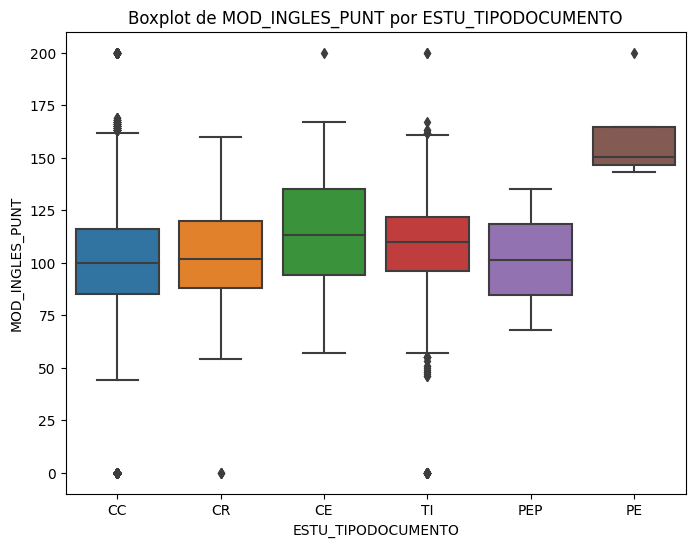

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
variables_categoricas = ['ESTU_TIPODOCUMENTO']
variables_de_interes = ['MOD_INGLES_PUNT']
df_subset = df[variables_categoricas + variables_de_interes]

# Crea un boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='ESTU_TIPODOCUMENTO', y='MOD_INGLES_PUNT', data=df_subset)
plt.xlabel('ESTU_TIPODOCUMENTO')
plt.ylabel('MOD_INGLES_PUNT')
plt.title('Boxplot de MOD_INGLES_PUNT por ESTU_TIPODOCUMENTO')
plt.show()

En el caso de la variable categorica 'ESTU_TIPODOCUMENTO', observamos que por su correlacion no tiene gran impacto sobre la variable objetivo, además en el boxplot podemos ver una relacion simular entre todos los tipos de documentos menos por PE(Permiso Especial de Permanencia) del cual solo hay 4 registros en todos los datos de esa columna, es por eso que no afecta a la variable objetivo esta variable categorica.

De aqui en adelante usaré la correlación o el boxplot para analizar las dummie variables y el analisis manual de cada variable para decidir

In [45]:
variables_categoricas = [
    'ESTU_NACIONALIDAD'
]
variables_categoricas.append('MOD_INGLES_PUNT')
df_dummies = pd.get_dummies(df[variables_categoricas], columns=variables_categoricas[:-1], drop_first=True)
correlation_matrix = df_dummies.corr(method='pearson')  # Método de Pearson
correlation_with_target = correlation_matrix['MOD_INGLES_PUNT'].sort_values(ascending=False)
print("\nCorrelación con la variable objetivo:")
print(correlation_with_target)


Correlación con la variable objetivo:
MOD_INGLES_PUNT                           1.000000
ESTU_NACIONALIDAD_VENEZUELA               0.020217
ESTU_NACIONALIDAD_EL SALVADOR             0.017489
ESTU_NACIONALIDAD_MÉXICO                  0.006580
ESTU_NACIONALIDAD_REPÚBLICA DOMINICANA    0.005037
ESTU_NACIONALIDAD_ECUADOR                 0.004555
ESTU_NACIONALIDAD_PANAMÁ                  0.004529
ESTU_NACIONALIDAD_PERÚ                    0.004458
ESTU_NACIONALIDAD_ESTADOS UNIDOS          0.004073
ESTU_NACIONALIDAD_ANTIGUA Y BARBUDA       0.003016
ESTU_NACIONALIDAD_CHILE                   0.002743
ESTU_NACIONALIDAD_HAITI                   0.001179
ESTU_NACIONALIDAD_BOLIVIA                -0.000074
ESTU_NACIONALIDAD_ESPAÑA                 -0.001810
ESTU_NACIONALIDAD_CANADÁ                 -0.002985
ESTU_NACIONALIDAD_NICARAGUA              -0.005668
ESTU_NACIONALIDAD_COLOMBIA               -0.024314
Name: MOD_INGLES_PUNT, dtype: float64


Por valores de correlación se descarta, hay mayoria de colombianos y venezolanos

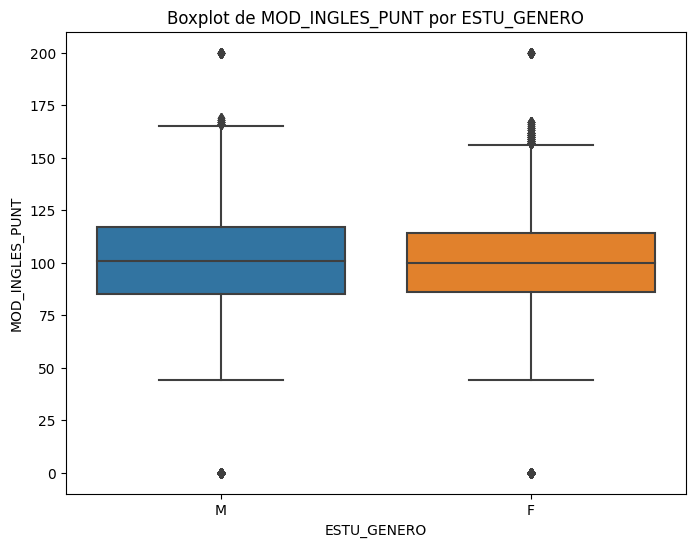

In [49]:
variables_categoricas = ['ESTU_GENERO']
variables_de_interes = ['MOD_INGLES_PUNT']
df_subset = df[variables_categoricas + variables_de_interes]
# Crea un boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(x='ESTU_GENERO', y='MOD_INGLES_PUNT', data=df_subset)
plt.xlabel('ESTU_GENERO')
plt.ylabel('MOD_INGLES_PUNT')
plt.title('Boxplot de MOD_INGLES_PUNT por ESTU_GENERO')
plt.show()

Con respecto a ESTU_GENERO, podemos decir que es una variable importante para el modelo al ser bien distribuida

Lista de variables categoricas que no se consideraron relevantes para el modelo:

- ESTU_TIPODOCUMENTO
- ESTU_NACIONALIDAD
- 

Una vez realizada la exploracion de datos, continuamos con train y test

In [9]:
from sklearn.model_selection import train_test_split
# Dividir los datos en un conjunto de entrenamiento (80%) y un conjunto de prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(df.drop('MOD_INGLES_PUNT', axis=1), df['MOD_INGLES_PUNT'], test_size=0.2, random_state=42)

In [11]:
from datetime import datetime

# Calcular la edad
now = datetime.now()
X_train['edad'] = now.year - pd.to_datetime(X_train['ESTU_FECHANACIMIENTO']).dt.year
X_test['edad'] = now.year - pd.to_datetime(X_test['ESTU_FECHANACIMIENTO']).dt.year

# Eliminar la columna 'fecha_nacimiento' si ya no la necesitas
X_train.drop('ESTU_FECHANACIMIENTO', axis=1, inplace=True)
X_test.drop('ESTU_FECHANACIMIENTO', axis=1, inplace=True)

In [13]:
X_train = pd.get_dummies(X_train, columns=['ESTU_GENERO'])
X_test = pd.get_dummies(X_test, columns=['ESTU_GENERO'])